In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, roc_curve, ConfusionMatrixDisplay
import joblib

In [2]:
df = pd.read_csv("heart_disease_cleaned.csv")
df

,age,trestbps,chol,thalach,oldpeak,ca,sex_Female,sex_Male,cp_Asymptomatic,cp_AtypicalAngina,...,restecg_STTAbnormality,exang_NoExAngina,exang_YesExAngina,slope_Downsloping,slope_Flat,slope_Upsloping,thal_FixedDefect,thal_Normal,thal_ReversibleDefect,heartdiseasepresence
0,63,145,233,150,2.3,0.0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0
1,67,160,286,108,1.5,3.0,0,1,1,0,...,0,0,1,0,1,0,0,1,0,1
2,67,120,229,129,2.6,2.0,0,1,1,0,...,0,0,1,0,1,0,0,0,1,1
3,37,130,250,187,3.5,0.0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
4,41,130,204,172,1.4,0.0,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,57,140,241,123,0.2,0.0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,1
268,45,110,264,132,1.2,0.0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,1
269,68,144,193,141,3.4,2.0,0,1,1,0,...,0,1,0,0,1,0,0,0,1,1
270,57,130,131,115,1.2,1.0,0,1,1,0,...,0,0,1,0,1,0,0,0,1,1


In [3]:
# creating the train test split here
X = df[df.columns[:-1]]
y = df["heartdiseasepresence"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
#use this for training model for the first time

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest
rf_base = RandomForestClassifier(random_state=42)

# Grid search with stratified 5-fold CV
grid = GridSearchCV(rf_base, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

# Use best estimator to predict and evaluate on test set
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("Best Accuracy:", accuracy_score(y_test, y_pred))
print("Best ROC AUC:", roc_auc_score(y_test, y_proba))
print("Best Precision:", precision_score(y_test, y_pred))
print("Best Recall:", recall_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf, X, y, cv=skf, scoring='accuracy')
print("Best Cross-validated accuracy (mean):", cv_scores.mean())
# ...existing code...


Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Accuracy: 0.8181818181818182
Best ROC AUC: 0.8888888888888888
Best Precision: 0.7931034482758621
Best Recall: 0.8518518518518519
Best Cross-validated accuracy (mean): 0.8127272727272727


In [ ]:
# if model already trained, run this cell instead of the above
best_rf = joblib.load("random_forest_model.joblib")

# Predict on new data (example: X_test)
y_pred_loaded = best_rf.predict(X_test)
y_proba_loaded = best_rf.predict_proba(X_test)[:, 1]

# Evaluate loaded model
print("Loaded model accuracy:", accuracy_score(y_test, y_pred_loaded))
print("Loaded model ROC AUC:", roc_auc_score(y_test, y_proba_loaded))
print("Best Precision:", precision_score(y_test, y_pred_loaded))
print("Best Recall:", recall_score(y_test, y_pred_loaded))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf, X, y, cv=skf, scoring='accuracy')
print("Best Cross-validated accuracy (mean):", cv_scores.mean())


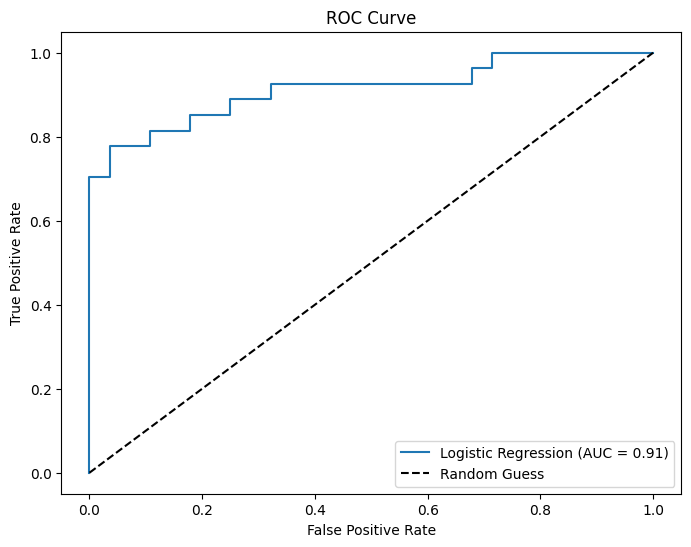

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

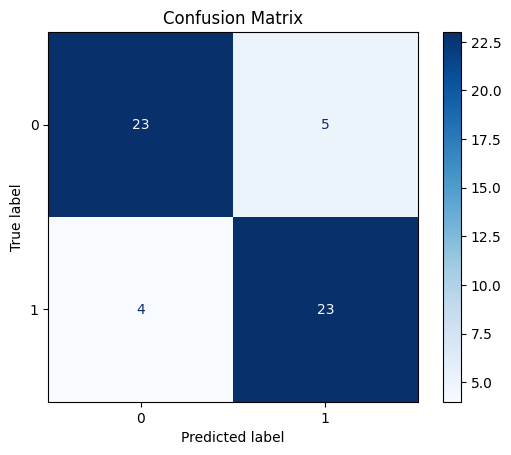

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
joblib.dump(best_rf, "random_forest_model.joblib")
print("Model saved as random_forest_model.joblib")
# ...existing code...

NameError: name 'best_lr' is not defined